# **Baseline**  

Now that we have two datasets (df and df_graph) with feature engineering completed:

Our main goal is to **predict train delays** at the next stop. This means:  
- **Input (`X`)**: Features related to train schedules, past delays, station characteristics, congestion, and network centrality (if using `df_graph`).  
- **Target (`y`)**: Next stop arrival delay (`stop_arrival_delay`).  

Our df_graph includes network-related centrality measures (PageRank, betweenness, closeness, etc.). 
Since we expect that the features extracted from the graph could help model how delays propagate across the railway network, we first train the models on the dataset without these features and then on the complete dataset. This allows us to evaluate their actual contribution to the prediction performance.

In this notebook we will only train and analyze the baseline model. We use XGBoost as the baseline model for our analysis. XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm known for its efficiency, scalability, and strong predictive performance. XGBoost operates using a gradient boosting framework, where weak learners (decision trees) are sequentially improved to minimize errors. The model benefits from advanced optimization techniques, such as tree pruning and a weighted quantile sketch, making it a robust choice for our problem.

## Preprocessing

In this section, we delete some columns that we left during the preprocessing phase since we might have needed them.

In [60]:
from pathlib import Path
import pandas as pd
import numpy as np

In [61]:
PROCESSED_PATH = Path("data/processed")
df = pd.read_parquet(PROCESSED_PATH / "train_data_fe.parquet")
df_graph = pd.read_parquet(PROCESSED_PATH / "train_data_fe_graph.parquet")

In [62]:
df.head()

,train_number,departure_station,train_departure_delay,arrival_station,scheduled_departure_time,scheduled_arrival_time,stop_name,stop_arrival_delay,stop_departure_delay,stop_departure_time,...,is_weekend,month,is_rush_hour,station_traffic,is_high_traffic_station,delay_change,is_delay_increasing,rolling_arrival_delay,rolling_departure_delay,historical_avg_delay
0,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,BOLOGNA C.LE,0.0,1.0,2024-09-30 22:38:00,...,0,9,0,161005,1,-1.0,0,NaN,NaN,0.297568
1,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,S.LAZZARO DI SAVENA,2.0,2.0,2024-09-30 22:46:00,...,0,9,0,14336,0,0.0,0,NaN,NaN,11.009852
2,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,OZZANO DELL'EMILIA,3.0,2.0,2024-09-30 22:52:00,...,0,9,0,14878,0,1.0,1,NaN,NaN,11.737624
3,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,CASTEL S.PIETRO TERME,3.0,4.0,2024-09-30 22:59:00,...,0,9,0,27351,1,-1.0,0,1.666667,1.666667,10.546798
4,17431,BOLOGNA C.LE,1.0,FAENZA,2024-09-30 22:38:00,2024-09-30 23:25:00,IMOLA,3.0,4.0,2024-09-30 23:08:00,...,0,9,0,42396,1,-1.0,0,2.666667,2.666667,9.186275


In [63]:
drop_cols = [
    "scheduled_departure_time", 
    "scheduled_arrival_time",
    "stop_departure_time",
    "departure_station", "arrival_station",
    "stop_name"
]

df = df.drop(columns=drop_cols)
df_graph = df_graph.drop(columns=drop_cols)

In [64]:
df.head()

,train_number,train_departure_delay,stop_arrival_delay,stop_departure_delay,is_terminal_stop,latitude,longitude,hour,day_of_week,is_weekend,month,is_rush_hour,station_traffic,is_high_traffic_station,delay_change,is_delay_increasing,rolling_arrival_delay,rolling_departure_delay,historical_avg_delay
0,17431,1.0,0.0,1.0,True,44.506260,11.342267,22,0,0,9,0,161005,1,-1.0,0,NaN,NaN,0.297568
1,17431,1.0,2.0,2.0,False,44.480970,11.416652,22,0,0,9,0,14336,0,0.0,0,NaN,NaN,11.009852
2,17431,1.0,3.0,2.0,False,44.450797,11.487297,22,0,0,9,0,14878,0,1.0,1,NaN,NaN,11.737624
3,17431,1.0,3.0,4.0,False,44.407376,11.597681,22,0,0,9,0,27351,1,-1.0,0,1.666667,1.666667,10.546798
4,17431,1.0,3.0,4.0,False,44.359418,11.718723,22,0,0,9,0,42396,1,-1.0,0,2.666667,2.666667,9.186275


In [65]:
df.columns

Index(['train_number', 'train_departure_delay', 'stop_arrival_delay',
       'stop_departure_delay', 'is_terminal_stop', 'latitude', 'longitude',
       'hour', 'day_of_week', 'is_weekend', 'month', 'is_rush_hour',
       'station_traffic', 'is_high_traffic_station', 'delay_change',
       'is_delay_increasing', 'rolling_arrival_delay',
       'rolling_departure_delay', 'historical_avg_delay'],
      dtype='object')

So at the end we keep:
- `train_number`
- `train_departure_delay`(Initial conditions)
- `stop_arrival_delay` (Target variable)
- `stop_departure_delay` (Useful for delay propagation)
- `latitude`, `longitude` (If geospatial patterns exist)
- `hour`, `day_of_week`, `is_weekend`, `is_rush_hour` (Time effects)
- `station_traffic`, `is_high_traffic_station` (Congestion indicators)
- `delay_change`, `is_delay_increasing` (Delay trends)
- `rolling_arrival_delay`, `rolling_departure_delay`, `historical_avg_delay` (Past delay patterns)

Particularly, the `train_number` identifies a specific sequence of stops. Even though there is some variability, the same train usually follows a consistent route.
It allows us to captures recurring delay patterns. Infact, some train numbers might systematically experience delays due to factors like priority, maintenance schedules, or traffic congestion.

The problem is that train_number is a categorical variable with many unique values (16585), which means that it cannot be used directly in models like Random Forest or XGBoost, and it can create overfitting if some train_numbers are rarely seen in training.

Instead of using train_number as a raw category, a solution could be replace it with the average delay of that train across the dataset (frequency encoding).

In [66]:
# Compute average delay per train number
train_delay_map = df.groupby("train_number")["stop_arrival_delay"].mean()

# Map to dataset
df["train_avg_delay"] = df["train_number"].map(train_delay_map)
df_graph["train_avg_delay"] = df_graph["train_number"].map(train_delay_map)

# Drop original column
df.drop(columns=["train_number"], inplace=True)
df_graph.drop(columns=["train_number"], inplace=True)


In [67]:
df.head(10)

,train_departure_delay,stop_arrival_delay,stop_departure_delay,is_terminal_stop,latitude,longitude,hour,day_of_week,is_weekend,month,is_rush_hour,station_traffic,is_high_traffic_station,delay_change,is_delay_increasing,rolling_arrival_delay,rolling_departure_delay,historical_avg_delay,train_avg_delay
0,1.0,0.0,1.0,True,44.506260,11.342267,22,0,0,9,0,161005,1,-1.0,0,NaN,NaN,0.297568,7.447720
1,1.0,2.0,2.0,False,44.480970,11.416652,22,0,0,9,0,14336,0,0.0,0,NaN,NaN,11.009852,7.447720
2,1.0,3.0,2.0,False,44.450797,11.487297,22,0,0,9,0,14878,0,1.0,1,NaN,NaN,11.737624,7.447720
3,1.0,3.0,4.0,False,44.407376,11.597681,22,0,0,9,0,27351,1,-1.0,0,1.666667,1.666667,10.546798,7.447720
4,1.0,3.0,4.0,False,44.359418,11.718723,22,0,0,9,0,42396,1,-1.0,0,2.666667,2.666667,9.186275,7.447720
5,1.0,1.0,2.0,False,44.325391,11.804174,22,0,0,9,0,33713,1,-1.0,0,3.000000,3.333333,5.823834,7.447720
6,1.0,-1.0,0.0,True,44.293594,11.883268,22,0,0,9,0,38825,1,-1.0,0,2.333333,3.333333,6.893401,7.447720
7,1.0,0.0,1.0,True,43.776893,11.247373,22,0,0,9,0,158887,1,-1.0,0,NaN,NaN,-0.016667,1.852035
8,1.0,0.0,1.0,False,43.800873,11.235729,22,0,0,9,0,86912,1,-1.0,0,NaN,NaN,2.157171,1.852035
9,1.0,0.0,1.0,False,43.819444,11.218380,22,0,0,9,0,22496,0,-1.0,0,NaN,NaN,1.561576,1.852035


In [68]:
df.describe()

,train_departure_delay,stop_arrival_delay,stop_departure_delay,latitude,longitude,hour,day_of_week,is_weekend,month,is_rush_hour,station_traffic,is_high_traffic_station,delay_change,is_delay_increasing,rolling_arrival_delay,rolling_departure_delay,historical_avg_delay,train_avg_delay
count,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.442963e+07,2.438093e+07,2.438093e+07,2.442963e+07,2.442963e+07
mean,2.722506e+00,2.950525e+00,4.080908e+00,4.351507e+01,1.140910e+01,1.112607e+01,2.749113e+00,2.236664e-01,6.437406e+00,2.820666e-01,4.077051e+04,5.003134e-01,-1.130383e+00,1.244483e-01,2.950950e+00,4.082825e+00,2.950525e+00,2.950525e+00
std,4.811160e+00,7.727990e+00,7.416356e+00,2.264055e+00,2.361894e+00,5.027670e+00,1.908661e+00,4.167010e-01,3.472078e+00,4.500056e-01,4.409048e+04,4.999999e-01,4.030244e+00,3.300923e-01,6.789874e+00,6.810943e+00,1.989974e+00,2.555226e+00
min,-9.000000e+00,-1.000000e+01,-1.000000e+01,3.673188e+01,6.709959e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-2.780000e+02,0.000000e+00,-1.000000e+01,-1.000000e+01,-1.000000e+01,-8.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,4.189614e+01,9.239100e+00,6.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,1.191500e+04,0.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,1.333333e+00,1.657268e+00,1.390176e+00
50%,2.000000e+00,1.000000e+00,2.000000e+00,4.433137e+01,1.134227e+01,1.100000e+01,3.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.396400e+04,1.000000e+00,-1.000000e+00,0.000000e+00,1.333333e+00,2.333333e+00,2.766497e+00,2.483371e+00
75%,3.000000e+00,4.000000e+00,5.000000e+00,4.543555e+01,1.279543e+01,1.500000e+01,4.000000e+00,0.000000e+00,1.000000e+01,1.000000e+00,5.149700e+04,1.000000e+00,0.000000e+00,0.000000e+00,3.666667e+00,4.666667e+00,4.018765e+00,3.899828e+00
max,2.890000e+02,3.000000e+02,2.990000e+02,4.700412e+01,1.816572e+01,2.300000e+01,6.000000e+00,1.000000e+00,1.200000e+01,1.000000e+00,2.559910e+05,1.000000e+00,3.000000e+02,1.000000e+00,2.966667e+02,2.970000e+02,2.000000e+02,2.693333e+02


In [9]:
df.dropna(inplace=True)
df_graph.dropna(inplace=True)

In [10]:
df.to_parquet(PROCESSED_PATH / "final_data.parquet")
df_graph.to_parquet(PROCESSED_PATH / "final_data_graph.parquet")

## **Train and Test Set Split**

 K-Fold Cross-Validation (K-Fold CV) is a great way to evaluate model performance more reliably by splitting the data into multiple train-test subsets. However, we need to be careful with time-series data (like train delays).

Standard K-Fold CV splits the data randomly into K equal-sized folds. But, when working with time series, a model might learn from future data and then be tested on past data. The time-dependent relationships are broken.

A solution is to apply Time-Series Aware K-Fold CV (TimeSeriesSplit).
This technique preserves the time order by ensuring that the training set always precedes the test set.
In this way we avoid data leakage by training only on past data and testing on future data, simulating real-world predictions where we use historical data to forecast upcoming delays.

![image](figures\tscv.png)


In [1]:
import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
PROCESSED_PATH = Path("data/processed")
RESULTS_PATH = Path("results")
MODELS_PATH = Path("models")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

In [55]:
# Load datasets
datasets = {
    "Base": pd.read_parquet(PROCESSED_PATH / "final_data.parquet"),
    "Graph": pd.read_parquet(PROCESSED_PATH / "final_data_graph.parquet"),
}

In [56]:
target_col = "stop_arrival_delay"
n_splits = 5  # Number of folds for time series cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)
results = {}

## **Training**

**Optuna** is used to manage the hyperparameters optimization process.

- `study_lgb`: is an Optuna study object. A study is the main component in Optuna that organizes and manages the optimization process. It keeps track of all trials and their corresponding results (i.e., the parameter sets and the evaluation metrics).
- `n_trials`: tells Optuna how many different sets of hyperparameters to try. In this case, Optuna will try 50 different hyperparameter configurations for the LightGBM model. Each trial will involve training a model with a unique set of parameters, then evaluating its performance (via MAE in this case). Optuna will track the results and find the set of parameters that yields the best performance (i.e., the lowest MAE).

Interesting to know:
1. **Trial Execution**: Optuna starts with a random set of hyperparameters, and evaluates the model's performance using cross-validation (defined in the objective function).
2. **Hyperparameter Adjustment**: After each trial, Optuna uses a **Bayesian optimization** approach to intelligently pick the next set of hyperparameters to try based on the results of previous trials. The optimization process typically becomes more efficient over time as it focuses on promising areas of the hyperparameter space. Infact, Optuna has built-in functionality to prune trials early if it detects that the current set of hyperparameters is unlikely to result in better performance (early-stopping).
3. **Best Parameters**: After completing the defined number of trials (`n_trials`), Optuna identifies the **best hyperparameter combination** that resulted in the lowest MAE.
4. **Model Re-training**: After the optimization process, the model is trained with the best-found hyperparameters on the full training dataset.

The goals of using Optuna, then, are several. First, it finds the optimal hyperparameters. Secondo, it improves model accuracy by reducing errors like MAE, RMSE, or increasing R². Third, it reduces overfitting by selecting hyperparameters that generalize well to unseen data.

In [ ]:
# Function to train and evaluate XGBoost on both the datasets
def train_xgboost(dataset_name, df):
    print(f"\nTraining on dataset: {dataset_name}")
    
    # Sort and split data
    df = df.sort_values(by=["month", "day_of_week", "hour"])    # Important the order for time series cross-validation
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    # Define optimization function for XGBoost
    def objective_xgb_gpu(trial):
        xgb_params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": trial.suggest_float("eta", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 1),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "seed": 42,
            "tree_method": "hist",
            "device": "cuda",
        }

        rmse_scores = []
        for train_idx, val_idx in tscv.split(X_scaled, y):
            X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = xgb.XGBRegressor(**xgb_params, n_estimators=500, early_stopping_rounds=50)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            preds = model.predict(X_val)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

        return np.mean(rmse_scores)

    # Run hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_xgb_gpu, n_trials=10)
    
    print(f"Best parameters for {dataset_name}: {study.best_params}")
    
    # Train final model with best hyperparameters
    best_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=500,
        early_stopping_rounds=50,
        seed=42,
        tree_method="hist",
        device="cuda",
        **study.best_params,
    )
    best_model.fit(X_scaled, y, eval_set=[(X_scaled, y)], verbose=False)
    
    # Save model and results
    model_filename = MODELS_PATH / f"xgb_{dataset_name.lower()}.pkl"
    results_filename = RESULTS_PATH / f"xgb_results_{dataset_name.lower()}.csv"
    
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)
    
    results[dataset_name] = study.best_value
    pd.DataFrame({"RMSE": [study.best_value]}).to_csv(results_filename, index=False)
    
    print(f"Model saved: {model_filename}")
    print(f"RMSE saved: {results_filename}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 5))
    sorted_idx = np.argsort(best_model.feature_importances_)[::-1]
    plt.bar(range(len(X.columns)), best_model.feature_importances_[sorted_idx], align="center")
    plt.xticks(range(len(X.columns)), [X.columns[i] for i in sorted_idx], rotation=90)
    plt.title(f"Feature Importance - {dataset_name}")
    plt.show()


Training on dataset: Base


[I 2025-03-27 18:41:45,004] A new study created in memory with name: no-name-7b76d69d-0171-4a17-916f-6950838d1d9f
[I 2025-03-27 18:42:17,447] Trial 0 finished with value: 2.139099522855349 and parameters: {'eta': 0.14264669785507952, 'max_depth': 10, 'subsample': 0.537026062599379, 'colsample_bytree': 0.6007195745366192, 'gamma': 0.46235180412666776, 'lambda': 0.018298504874939874, 'alpha': 0.1600809686964874}. Best is trial 0 with value: 2.139099522855349.
[I 2025-03-27 18:42:49,407] Trial 1 finished with value: 2.075761739158137 and parameters: {'eta': 0.06223269764021492, 'max_depth': 7, 'subsample': 0.6235402740541597, 'colsample_bytree': 0.7852830831149691, 'gamma': 0.16849057228120656, 'lambda': 0.016241091678212763, 'alpha': 0.11132274410726295}. Best is trial 1 with value: 2.075761739158137.
[I 2025-03-27 18:43:16,702] Trial 2 finished with value: 2.166839839807664 and parameters: {'eta': 0.21620905903352883, 'max_depth': 10, 'subsample': 0.5219668987993668, 'colsample_bytree':

Best parameters for Base: {'eta': 0.010378593572439938, 'max_depth': 8, 'subsample': 0.6127237512686579, 'colsample_bytree': 0.9671194964566547, 'gamma': 0.5406476721047894, 'lambda': 4.791582739788599e-08, 'alpha': 1.7794823839860353e-08}
Model saved: models\xgb_base.pkl
RMSE saved: results\results_base.csv


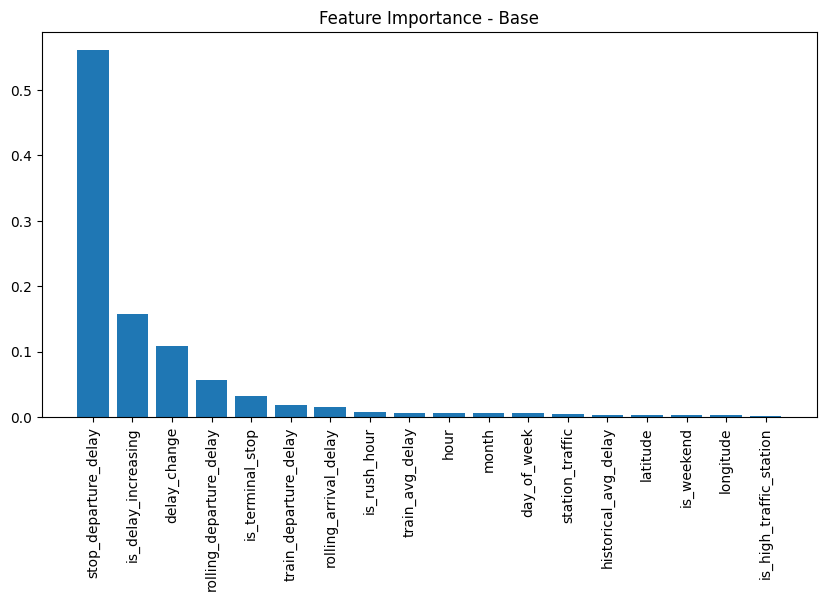


Training on dataset: Graph


[I 2025-03-27 18:47:44,456] A new study created in memory with name: no-name-0a8cdc1c-7398-4f07-ba46-7da2bda0416d
[I 2025-03-27 18:48:07,941] Trial 0 finished with value: 2.1033915333596824 and parameters: {'eta': 0.24645670981499698, 'max_depth': 5, 'subsample': 0.5437090618329494, 'colsample_bytree': 0.7911250817262832, 'gamma': 0.9638365182826457, 'lambda': 0.004639434559168625, 'alpha': 2.008835112190618e-08}. Best is trial 0 with value: 2.1033915333596824.
[I 2025-03-27 18:48:45,309] Trial 1 finished with value: 2.08832378878256 and parameters: {'eta': 0.10002634865289087, 'max_depth': 7, 'subsample': 0.7418062477618133, 'colsample_bytree': 0.542080035705143, 'gamma': 0.6304647481615548, 'lambda': 4.50108571013701e-07, 'alpha': 1.5521726022288097e-08}. Best is trial 1 with value: 2.08832378878256.
[I 2025-03-27 18:49:06,800] Trial 2 finished with value: 2.090894386158402 and parameters: {'eta': 0.27387328072982675, 'max_depth': 6, 'subsample': 0.8193385864093943, 'colsample_bytree

Best parameters for Graph: {'eta': 0.03319901251743791, 'max_depth': 6, 'subsample': 0.7712155244213439, 'colsample_bytree': 0.6104232694922898, 'gamma': 0.7951751732021237, 'lambda': 0.024086577472327838, 'alpha': 2.0070264325457784e-08}
Model saved: models\xgb_graph.pkl
RMSE saved: results\results_graph.csv


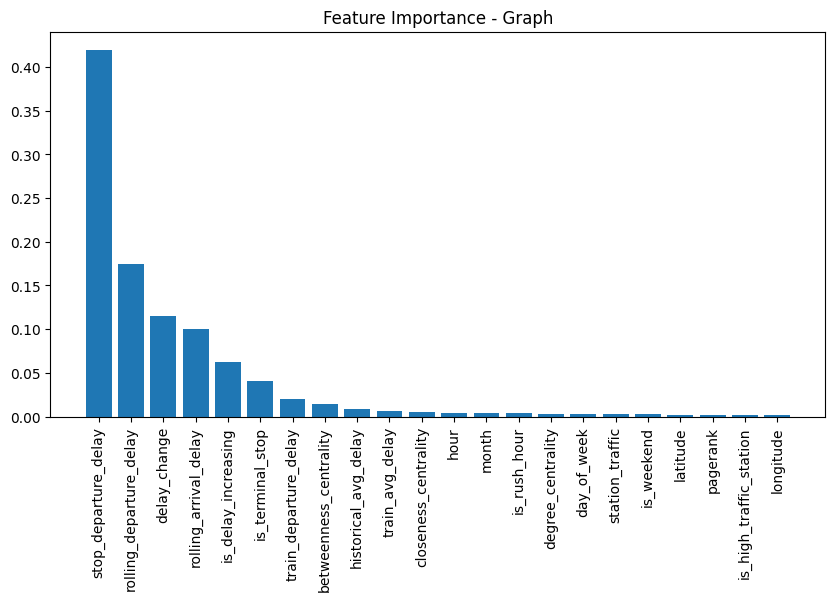

In [58]:
for name, df in datasets.items():
    train_xgboost(name, df)

In [59]:
print("\nFinal Results:")
for dataset, rmse in results.items():
    print(f"{dataset}: RMSE = {rmse:.4f}")


Final Results:
Base: RMSE = 2.0713
Graph: RMSE = 2.0774


## **Evaluation**  

Contrary to our expectations, the extra graph-based features may not add useful predictive power. In fact, they could be introducing noise rather than improving the model. We will see if this behavior is confirmed by later models.

But leaving out the comparison for a moment, let's analyze the result in general. 

As df.describe() shows at the beginning of this notebook, the target variable (`stop_arrival_delay`) has the following characteristics:  
- **Mean:** 2.95  
- **Standard deviation:** 7.73  
- **Median (50th percentile):** 1.0  
- **75th percentile:** 4.0  
- **Max:** 300.0

This means that:
- The median delay is just 1 minute, meaning most delays are small (ss already seen in data exploration).  
- The mean (2.95) is higher than the median, suggesting right-skewed distribution (some extreme delays).  
- The high standard deviation (7.73) indicates wide variability, likely due to rare but extreme delays.  

In other words, most train delays are characterized by relatively small time variations. The majority of delays are concentrated in the lower range, with occasional extreme outliers. This distribution makes RMSE an ideal metric for our model evaluation for several key reasons. In fact, transportation systems prioritize consistency and minimal deviation. By optimizing for RMSE, we minimize frequent, small prediction errors, we reduce the overall variability in delay predictions and we create a model that performs consistently across most scenarios

In our specific case, RMSE of ~2.07 means that, on average, the model's prediction error is around 2.07 minutes. Since most delays are small (0–4 minutes), an RMSE of 2.07 minutes suggests the model performs **reasonably well** in predicting common short delays. Of course, this metric alone does not tell us how the model behaves when predicting **large delays**, that we can consider outliers. 
The model may underpredict large delays, producing estimates that are closer to the mean (2.95 min) rather than accurately capturing outliers.  

Let us continue with our evaluation, and look at the values of additional metrics, this time on the entire datasets.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [ ]:
def evaluate_model(model_filename, dataset_name, X, y):
    print(f"\nEvaluating model: {dataset_name}")
    
    with open(model_filename, "rb") as f:
        model = pickle.load(f)

    y_pred = model.predict(X)

    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    print(f"{dataset_name} - MAE: {mae:.4f}")
    print(f"{dataset_name} - RMSE: {rmse:.4f}")
    print(f"{dataset_name} - R² Score: {r2:.4f}")

    return {"Dataset": dataset_name, "MAE": mae, "RMSE": rmse, "R²": r2}

datasets = {
    "Base": pd.read_parquet(PROCESSED_PATH / "final_data.parquet"),
    "Graph": pd.read_parquet(PROCESSED_PATH / "final_data_graph.parquet"),
}

results = []
for name, df in datasets.items():
    df = df.sort_values(by=["month", "day_of_week", "hour"])
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    model_filename = MODELS_PATH / f"xgb_{name.lower()}.pkl"
    res = evaluate_model(model_filename, name, X_scaled, y)
    results.append(res)

df_results = pd.DataFrame(results)
df_results.to_csv(RESULTS_PATH / "xgb_evaluation_metrics.csv", index=False)

print("\nMetrics saved in results/evaluation_metrics.csv")



Evaluating model: Base
Base - MAE: 0.1776
Base - RMSE: 1.8746
Base - R² Score: 0.9411

Evaluating model: Graph
Graph - MAE: 0.2150
Graph - RMSE: 1.9201
Graph - R² Score: 0.9382

Metrics saved in results/evaluation_metrics.csv


In this evaluation we also consider MAE and R^2. R^2 is a statistical measure that represents the proportion of the variance in the dependent variable (in this case, train arrival delays) that is predictable from the independent variables in your model.

On all the dataset, both models demonstrate better predictive performance, with R^2 scores above 0.93, and, according to the MAE, the predictions are typically within ~0.18-0.22 minutes of actual delays.

## **Train XGB on dataset with Embeddings**

In the initial phase of experimentation, the XGBoost models were trained and evaluated on two datasets: the base dataset and an extended version enriched with handcrafted graph-derived features. Following these experiments, additional LSTM models were developed and tested, including a variant trained on **graph embeddings** generated through a Node2Vec algorithm applied to the railway network graph.

Interestingly, the results showed that the LSTM model trained on graph embeddings outperformed the other LSTM variants, indicating that the embeddings were able to capture relevant structural information from the railway network, beyond what was explicitly encoded in the handcrafted graph features.

Motivated by these findings, we decided to further investigate the contribution of graph embeddings by integrating them into the XGBoost framework. This decision is based on the hypothesis that, given XGBoost's superior performance and lower variance compared to LSTM models, combining it with the additional structural knowledge embedded in the graph embeddings may lead to further improvements in predictive accuracy without compromising efficiency and interpretability.

This experiment aims to assess whether the latent structural relationships learned through the Node2Vec embeddings can enhance XGBoost's predictive capabilities, providing a more informative feature space for the regression task.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import optuna
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
PROCESSED_PATH = Path("data/processed")
MODELS_PATH = Path("models")
RESULTS_PATH = Path("results")

In [4]:
df = pd.read_parquet(PROCESSED_PATH / "train_data_fe.parquet")
embedding = pd.read_csv(Path("other") / "station_embeddings.csv")

df = df.merge(embedding, left_on="stop_name", right_on="station_name", how="left")
df.drop(columns=["station_name"], inplace=True)

drop_cols = [
    "scheduled_departure_time", "scheduled_arrival_time", "stop_departure_time",
    "departure_station", "arrival_station", "stop_name"
]
df.drop(columns=drop_cols, inplace=True)

df["train_avg_delay"] = df.groupby("train_number")["stop_arrival_delay"].transform("mean")
df.drop(columns=["train_number"], inplace=True)
df.dropna(inplace=True)

embedding_cols = [col for col in df.columns if col.startswith('0') or col.isdigit()]

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
embedding_pca = pca.fit_transform(df[embedding_cols])

pca_cols = [f"embed_pca_{i}" for i in range(embedding_pca.shape[1])]
df[pca_cols] = embedding_pca
df.drop(columns=embedding_cols, inplace=True)

In [6]:
n_splits = 5
target_col = "stop_arrival_delay"
tscv = TimeSeriesSplit(n_splits=n_splits)

In [7]:
def train_xgboost(df):
    df = df.sort_values(by=["month", "day_of_week", "hour"])
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    def objective_xgb_gpu(trial):
        xgb_params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": trial.suggest_float("eta", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 1),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "seed": 42,
            "tree_method": "hist",
            "device": "cuda",
        }

        rmse_scores = []
        for train_idx, val_idx in tscv.split(X_scaled, y):
            X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = xgb.XGBRegressor(**xgb_params, n_estimators=500, early_stopping_rounds=50)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            preds = model.predict(X_val)
            rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))

        return np.mean(rmse_scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_xgb_gpu, n_trials=10)
    
    print(f"Best parameters: {study.best_params}")
    
    best_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=500,
        early_stopping_rounds=50,
        seed=42,
        tree_method="hist",
        device="cuda",
        **study.best_params,
    )
    best_model.fit(X_scaled, y, eval_set=[(X_scaled, y)], verbose=False)
    
    model_filename = MODELS_PATH / "xgb_embedding.pkl"
    results_filename = RESULTS_PATH / "xgb_embedding_results.csv"
    
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)
    
    pd.DataFrame({"RMSE": [study.best_value]}).to_csv(results_filename, index=False)
    print(f"Model saved: {model_filename}")
    print(f"RMSE saved: {results_filename}")

    plt.figure(figsize=(10, 5))
    sorted_idx = np.argsort(best_model.feature_importances_)[::-1]
    plt.bar(range(len(X.columns)), best_model.feature_importances_[sorted_idx], align="center")
    plt.xticks(range(len(X.columns)), [X.columns[i] for i in sorted_idx], rotation=90)
    plt.title("Feature Importance")
    plt.show()

def evaluate_model(model_filename, X, y):
    print("\nEvaluating model")
    with open(model_filename, "rb") as f:
        model = pickle.load(f)
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

[I 2025-03-29 17:30:43,700] A new study created in memory with name: no-name-17909662-282a-44cc-adcd-d3d45af28ef8
c:\Users\Ningo\projects\dynamic-train-delay-prediction-system\.venv\lib\site-packages\xgboost\core.py:729: UserWarning: [17:30:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-03-29 17:31:42,383] Trial 0 finished with value: 2.1012922066671136 and parameters: {'eta': 0.03656406075696724, 'max_depth': 4, 'subsample': 0.7623637503206045, 'colsample_bytree': 0.7902463211693946, 'gamma': 0.07861738753968739, 'lambda': 0.00027543908681

Best parameters: {'eta': 0.05913047391018099, 'max_depth': 7, 'subsample': 0.5657985510646065, 'colsample_bytree': 0.8603659211160308, 'gamma': 0.870173760891264, 'lambda': 4.867715395622529e-05, 'alpha': 5.981856902338056e-07}
Model saved: models\xgb_embedding.pkl
RMSE saved: results\xgb_embedding_results.csv


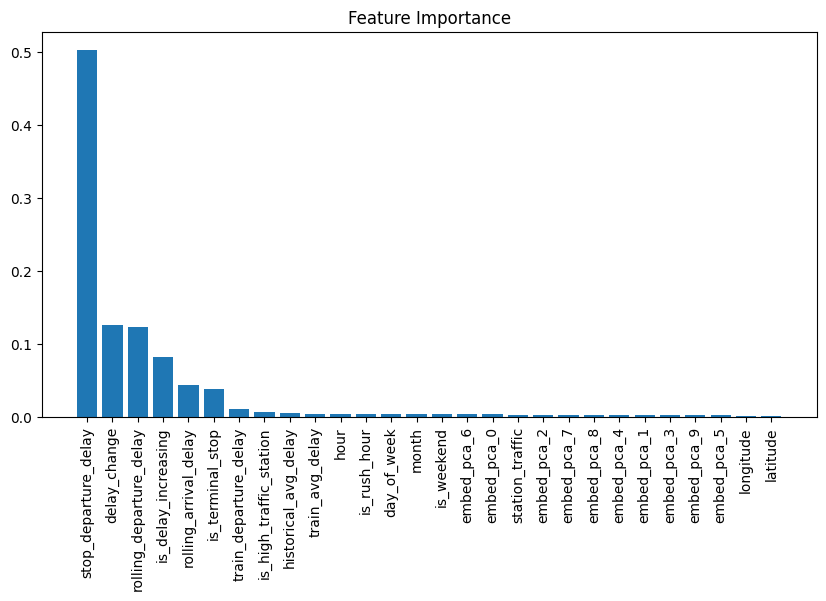


Evaluating model
MAE: 0.1733, RMSE: 1.6715, R² Score: 0.9532
Metrics saved in results/xgb_embedding_evaluation_metrics.csv


In [8]:
train_xgboost(df)

X = df.drop(columns=[target_col])
y = df[target_col]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

results = evaluate_model(MODELS_PATH / "xgb_embedding.pkl", X_scaled, y)
pd.DataFrame([results]).to_csv(RESULTS_PATH / "xgb_embedding_evaluation_metrics.csv", index=False)
print("Metrics saved in results/xgb_embedding_evaluation_metrics.csv")


The intuition behind integrating graph embeddings into the XGBoost model has proven to be correct. The model trained on the dataset enriched with Node2Vec embeddings achieved the best performance among all XGBoost variants tested, confirming that the structural information encoded in the embeddings effectively enhances the model's ability to predict train delays.